In [87]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [119]:
results = pd.read_csv("JC_WARD_D_edited.csv", header=0, error_bad_lines=False, verbose=False, encoding="UTF-7")

In [120]:
results = results.drop('Unnamed: 8', axis=1)

### Questions to Ask

1. How was turnout by district, race?
2. Did Mo's supporters come out and vote?
3. Did our model accurately predict who would vote?

### First clean data

In [121]:
def get_last(string):
    return(str(string).split("|")[0])
def get_first(string):
    try:
        return(str(string).split("|")[1])
    except:
        return("")
def get_middle(string):
    try:
        return(str(string).split("|")[2])
    except:
        return("")

results["last_name"] = results.Voter_Name.apply(get_last)
results["first_name"] = results.Voter_Name.apply(get_first)
results["middle_name"] = results.Voter_Name.apply(get_middle)

### Add race

In [122]:
url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/most-common-name/surnames.csv'
races = pd.read_csv(url,index_col=0)

In [123]:
races["last_name"] = races.index
races = races.reset_index()
races.head()

,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,last_name
0,SMITH,1,2376206,880.85,880.85,73.35,22.22,0.4,0.85,1.63,1.56,SMITH
1,JOHNSON,2,1857160,688.44,1569.30,61.55,33.8,0.42,0.91,1.82,1.5,JOHNSON
2,WILLIAMS,3,1534042,568.66,2137.96,48.52,46.72,0.37,0.78,2.01,1.6,WILLIAMS
3,BROWN,4,1380145,511.62,2649.58,60.71,34.54,0.41,0.83,1.86,1.64,BROWN
4,JONES,5,1362755,505.17,3154.75,57.69,37.73,0.35,0.94,1.85,1.44,JONES


In [124]:
def get_race(arow): 
    if arow["pctblack"]=="((S))":
        arow["pctblack"] = 0.00
    if arow["pctaian"]=="((S))":
        arow["pctaian"] = 0.00
    try:
        guess = arow[["pctwhite", "pctblack", "pctapi", "pctaian", "pct2prace", "pcthispanic"]].astype(float).idxmax(axis=1)
        return(guess)
    except:
        return("Unidentified")

In [125]:
mapping = {'(S)':.00001}
races = races.replace({'pctblack': mapping, 'pctaian': mapping,
               'pctwhite': mapping, 'pctapi': mapping, 
               'pct2prace': mapping, 'pcthispanic': mapping})

In [126]:
races["guess"] = races.apply(lambda x: get_race(x), axis=1)

In [127]:
races["guess"] = races.guess.str.replace("pct", "")

In [191]:
races.head()

,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,last_name,guess
0,SMITH,1,2376206,880.85,880.85,73.35,22.22,0.4,0.85,1.63,1.56,SMITH,white
1,JOHNSON,2,1857160,688.44,1569.30,61.55,33.8,0.42,0.91,1.82,1.5,JOHNSON,white
2,WILLIAMS,3,1534042,568.66,2137.96,48.52,46.72,0.37,0.78,2.01,1.6,WILLIAMS,white
3,BROWN,4,1380145,511.62,2649.58,60.71,34.54,0.41,0.83,1.86,1.64,BROWN,white
4,JONES,5,1362755,505.17,3154.75,57.69,37.73,0.35,0.94,1.85,1.44,JONES,white


In [192]:
results.head()

,Voter_ID,Voter_Name,Ballot_Type,Residence_Address,Zip_Code,Party,Wd_VotI,Dist_VotI,last_name,first_name,middle_name
0,110011008,ACOSTA| WILGABRIEL,M,10 CAMBRIDGE AVE AptUnit 3,7307,UNA,4.0,1.0,ACOSTA,WILGABRIEL,
1,110580340,ALONSO| EDUARDO,M,9 CAMBRIDGE AVE AptUnit 2,7307,CNV,4.0,1.0,ALONSO,EDUARDO,
2,150695981,AMADOR| FAUSTINO,M,51 CAMBRIDGE AVE AptUnit 1,7307,DEM,4.0,1.0,AMADOR,FAUSTINO,
3,150189009,ASTUDILLO| ROBERT| C,M,133 GRIFFITH ST,7307,DEM,4.0,1.0,ASTUDILLO,ROBERT,C
4,110114794,BAKER| CHRISTOPHER| M,M,12 CAMBRIDGE AVE,7307,DEM,4.0,1.0,BAKER,CHRISTOPHER,M


In [128]:
races.groupby("guess")["name"].count()

guess
2prace         140
aian           547
api           6562
black         5882
hispanic      8212
white       130327
Name: name, dtype: int64

In [129]:
results.groupby("Dist_VotI")["Voter_ID"].count()

Dist_VotI
1.0     180
2.0     180
3.0     212
4.0     306
5.0     276
6.0     206
7.0     250
8.0     227
9.0     255
10.0    243
11.0    148
12.0    240
13.0    365
14.0    154
15.0    252
16.0    161
17.0    213
18.0    181
19.0    213
20.0    277
21.0    228
22.0    228
23.0    161
24.0    145
25.0    243
26.0    195
27.0    260
28.0     74
29.0    235
31.0      1
Name: Voter_ID, dtype: int64

In [130]:
results_race = pd.merge(results, races, on="last_name", how="left")

In [131]:
results_race.guess.fillna("Unidentified", inplace=True)

In [132]:
results_race.groupby(["Dist_VotI", "guess"])["Voter_ID"].count().fillna(0).replace('NaN', 0).unstack().head()

guess,2prace,Unidentified,api,black,hispanic,white
Dist_VotI,,,,,,
1.0,NaN,22.0,23.0,1.0,63.0,71.0
2.0,NaN,29.0,30.0,3.0,56.0,62.0
3.0,1.0,42.0,14.0,5.0,52.0,98.0
4.0,3.0,58.0,8.0,4.0,71.0,162.0
5.0,1.0,37.0,10.0,2.0,100.0,126.0


In [133]:
sns.heatmap(results_race.groupby(["Dist_VotI", "guess"])["Voter_ID"].count().fillna(0).replace('NaN', 0).unstack())

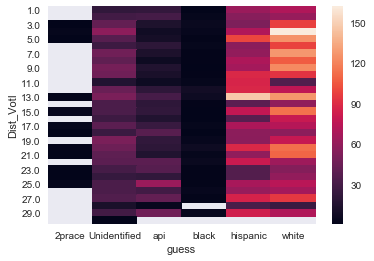

In [134]:
plt.show()

### Did Mo's Supporters Come Out and Vote?

In [225]:
mo_base = pd.read_csv("Election Day Mo Supporter List - Master 11052017.csv", 
                     names = ["first_name", "last_name", "full_name", "address", "Dist_VotI", "email", "phone"])

In [226]:
mo_base["mo_supporter"] = int(1)

In [227]:
results_race['first_name'] = results_race['first_name'].apply(lambda x: x.strip(" "))

In [228]:
results_race['last_name'] = results_race['last_name'].apply(lambda x: x.strip(" "))

In [229]:
mo_base['first_name'] = mo_base['first_name'].astype(str).apply(lambda x: x.strip(" "))
mo_base['last_name'] = mo_base['last_name'].astype(str).apply(lambda x: x.strip(" "))

mo_base['first_name'] = mo_base['first_name'].astype(str).apply(lambda x: x.split(',', 1)[0])

In [230]:
results_race_mo = pd.merge(results_race, mo_base[["first_name", "last_name", "mo_supporter"]],
                          on=["last_name", "first_name"], how="left")

In [231]:
results_race_mo.head()

,Voter_ID,Voter_Name,Ballot_Type,Residence_Address,Zip_Code,Party,Wd_VotI,Dist_VotI,last_name,first_name,...,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,guess,mo_supporter
0,110011008,ACOSTA| WILGABRIEL,M,10 CAMBRIDGE AVE AptUnit 3,7307,UNA,4.0,1.0,ACOSTA,WILGABRIEL,...,28.35,29508.57,8.04,0.69,2.36,0.29,0.63,87.99,hispanic,NaN
1,110580340,ALONSO| EDUARDO,M,9 CAMBRIDGE AVE AptUnit 2,7307,CNV,4.0,1.0,ALONSO,EDUARDO,...,7.71,46058.33,9.28,0.2,0.92,0.17,0.4,89.02,hispanic,NaN
2,150695981,AMADOR| FAUSTINO,M,51 CAMBRIDGE AVE AptUnit 1,7307,DEM,4.0,1.0,AMADOR,FAUSTINO,...,5.93,49417.15,9.6,0.26,1.54,0.44,0.61,87.54,hispanic,NaN
3,150189009,ASTUDILLO| ROBERT| C,M,133 GRIFFITH ST,7307,DEM,4.0,1.0,ASTUDILLO,ROBERT,...,0.72,71834.70,4.77,1e-05,4.77,1e-05,0.36,89.89,hispanic,NaN
4,110114794,BAKER| CHRISTOPHER| M,M,12 CAMBRIDGE AVE,7307,DEM,4.0,1.0,BAKER,CHRISTOPHER,...,153.23,10784.51,82.08,13.63,0.45,0.83,1.54,1.47,white,NaN


In [232]:
results_race_mo.fillna(0, inplace=True)

In [233]:
results_race_mo.mo_supporter.describe()

count    6369.000000
mean        0.129377
std         0.335643
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: mo_supporter, dtype: float64

In [234]:
mo_base[(mo_base.last_name=="MUNOZ") & (mo_base.first_name=="DAISY")]

,first_name,last_name,full_name,address,Dist_VotI,email,phone,mo_supporter
0,DAISY,MUNOZ,DAISYMUNOZ,112 FRANKLIN STREET,1,NaN,2016531621,1


In [235]:
results_race_mo[(results_race_mo.last_name=="MUNOZ") & (results_race_mo.first_name=="DAISY")]

,Voter_ID,Voter_Name,Ballot_Type,Residence_Address,Zip_Code,Party,Wd_VotI,Dist_VotI,last_name,first_name,...,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,guess,mo_supporter
104,150527999,MUNOZ| DAISY| M,M,112 FRANKLIN ST AptUnit 1,7307,DEM,4.0,1.0,MUNOZ,DAISY,...,43.66,24526.31,5.52,0.3,0.88,0.29,0.41,92.61,hispanic,1.0


In [236]:
mo_base[(mo_base.last_name=="MIGLIORE")]

,first_name,last_name,full_name,address,Dist_VotI,email,phone,mo_supporter
1096,ELIZABETH,MIGLIORE,"ELIZABETH, AMIGLIORE",100 MANHATTAN AVE 1R,20,NaN,NaN,1


In [238]:
results_race_mo[(results_race_mo.last_name=="DOOHAN") & (results_race_mo.first_name=="BRENDAN")]

,Voter_ID,Voter_Name,Ballot_Type,Residence_Address,Zip_Code,Party,Wd_VotI,Dist_VotI,last_name,first_name,...,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,guess,mo_supporter
4358,104597805,DOOHAN| BRENDAN| C,M,100 MANHATTAN AVE AptUnit 1R,73073027,DEM,4.0,20.0,DOOHAN,BRENDAN,...,0.08,86210.69,98.55,0,1e-05,0,1e-05,1e-05,white,1.0


In [244]:
results_race_mo.head()

,Voter_ID,Voter_Name,Ballot_Type,Residence_Address,Zip_Code,Party,Wd_VotI,Dist_VotI,last_name,first_name,...,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,guess,mo_supporter
0,110011008,ACOSTA| WILGABRIEL,M,10 CAMBRIDGE AVE AptUnit 3,7307,UNA,4.0,1.0,ACOSTA,WILGABRIEL,...,28.35,29508.57,8.04,0.69,2.36,0.29,0.63,87.99,hispanic,0.0
1,110580340,ALONSO| EDUARDO,M,9 CAMBRIDGE AVE AptUnit 2,7307,CNV,4.0,1.0,ALONSO,EDUARDO,...,7.71,46058.33,9.28,0.2,0.92,0.17,0.4,89.02,hispanic,0.0
2,150695981,AMADOR| FAUSTINO,M,51 CAMBRIDGE AVE AptUnit 1,7307,DEM,4.0,1.0,AMADOR,FAUSTINO,...,5.93,49417.15,9.6,0.26,1.54,0.44,0.61,87.54,hispanic,0.0
3,150189009,ASTUDILLO| ROBERT| C,M,133 GRIFFITH ST,7307,DEM,4.0,1.0,ASTUDILLO,ROBERT,...,0.72,71834.70,4.77,1e-05,4.77,1e-05,0.36,89.89,hispanic,0.0
4,110114794,BAKER| CHRISTOPHER| M,M,12 CAMBRIDGE AVE,7307,DEM,4.0,1.0,BAKER,CHRISTOPHER,...,153.23,10784.51,82.08,13.63,0.45,0.83,1.54,1.47,white,0.0


In [239]:
results_race_mo.to_csv("results_race_mo.csv")

### QGIS

In [250]:
x = results_race_mo.groupby(["Dist_VotI", "guess"])["Voter_ID"].count().unstack()
races_dist = pd.DataFrame(x)
races_dist["District"] = races_dist.index

x = results_race_mo.groupby("Dist_VotI")["mo_supporter"].sum()
mo_votes = pd.DataFrame(x)
mo_votes["District"] = mo_votes.index

In [252]:
x = results_race_mo.groupby("Dist_VotI")["Voter_ID"].count()
votes = pd.DataFrame(x)
votes["District"] = votes.index

In [253]:
qgis = pd.merge(races_dist, mo_votes, on="District", how="inner")

In [255]:
qgis_final = pd.merge(qgis, votes, on="District", how="inner")

In [256]:
qgis_final.head()

,2prace,Unidentified,api,black,hispanic,white,District,mo_supporter,Voter_ID
0,NaN,12.0,NaN,NaN,NaN,NaN,0.0,0.0,12
1,NaN,23.0,23.0,1.0,63.0,72.0,1.0,21.0,182
2,NaN,29.0,30.0,3.0,56.0,62.0,2.0,32.0,180
3,1.0,42.0,14.0,5.0,53.0,98.0,3.0,32.0,213
4,3.0,58.0,8.0,4.0,71.0,164.0,4.0,56.0,308


In [258]:
actuals = pd.read_csv("Actuals_Election.csv")

In [260]:
qgis_final2 = pd.merge(qgis_final, actuals, on="District", how="inner")

In [261]:
qgis_final2.head()

,2prace,Unidentified,api,black,hispanic,white,District,mo_supporter,Voter_ID,Carmen Vega (1C),Michael Yun (3C),Moriah Kinberg (5C),Rafael Torres (7C),mo_percentage
0,NaN,23.0,23.0,1.0,63.0,72.0,1,21.0,182,16,80,25,3,20.16%
1,NaN,29.0,30.0,3.0,56.0,62.0,2,32.0,180,7,61,22,3,23.66%
2,1.0,42.0,14.0,5.0,53.0,98.0,3,32.0,213,14,77,68,2,42.24%
3,3.0,58.0,8.0,4.0,71.0,164.0,4,56.0,308,12,94,117,3,51.77%
4,1.0,37.0,10.0,2.0,101.0,127.0,5,40.0,278,12,118,73,5,35.10%


In [262]:
qgis_final2.to_csv("QGIS_input.csv", index=False)

### QGIS done

In [146]:
#results_race_mo = pd.read_csv("results_race_mo.csv")

In [147]:
mo_groupby = mo_base.groupby("Dist_VotI", as_index=False).mo_supporter.count() 

In [148]:
results_race_mo["Dist_VotI"] = results_race_mo.Dist_VotI_x.astype(str).copy()

In [149]:
mo_groupby["Dist_VotI"] = mo_groupby.Dist_VotI.astype(str).copy()

In [150]:
results_race_mo["Dist_VotI"] = results_race_mo.Dist_VotI_x.copy()

In [151]:
results_groupby = pd.DataFrame(
        results_race_mo.groupby(["Dist_VotI", "mo_supporter"])["Voter_ID"].count().fillna(0).replace('NaN', 0)
    )

In [152]:
results_groupby = results_groupby.unstack()
results_groupby["Dist_VotI"] = results_groupby.index
results_groupby["Dist_VotI"] = results_groupby["Dist_VotI"].round(0)

In [153]:
results_groupby.head()

Voter_ID       Dist_VotI
mo_supporter      0.0   1.0          
Dist_VotI                            
0.0              12.0   NaN       0.0
1.0             164.0  16.0       1.0
2.0             158.0  22.0       2.0
3.0             189.0  24.0       3.0
4.0             255.0  53.0       4.0

In [154]:
mo_groupby = mo_groupby.convert_objects(convert_numeric=True)

/Users/brendandoohan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [155]:
mo_groupby.head()

,Dist_VotI,mo_supporter
0,1.0,45
1,10.0,51
2,11.0,41
3,12.0,53
4,13.0,139


In [156]:
mo_turnout = pd.merge(
    results_groupby,
    mo_groupby,
    on="Dist_VotI",
    how="inner")

In [157]:
mo_turnout.columns = ["District", "Total_Voters", "Mo_Voters", "District_x", "Mo_supporters"]

In [158]:
mo_turnout["turnout_rate"] = mo_turnout["Mo_Voters"]/ mo_turnout.Mo_supporters

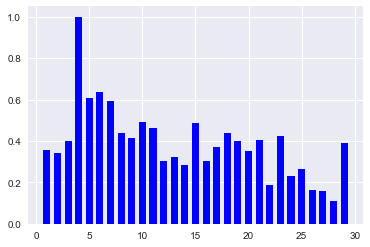

In [159]:
import matplotlib.pyplot as plt
#import plotly.plotly as py
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

y = mo_turnout.turnout_rate
x = mo_turnout.District
width = 1/1.5
plt.bar(x, y, width, color="blue")
#fig = plt.gcf()
#plot_url = py.plot_mpl(fig, filename='mpl-basic-bar')
plt.show()

In [160]:
probs = pd.read_csv("voters_with_petition_flag.csv")

In [161]:
probs["Voter_ID"] = probs["VOTER.ID"].astype(str)
results_race_mo["Voter_ID"] = results_race_mo["Voter_ID"].astype(str) 

In [162]:
model_eval = pd.merge(probs[["Voter_ID", "LAST.NAME", "FIRST.NAME", 
                             "likely_to_vote"]], results_race_mo, on="Voter_ID", how="left")

In [163]:
model_eval = pd.read_csv("model_eval.csv")

In [164]:
#model_eval.to_csv("model_eval.csv", index=False)

In [165]:
model_eval["pred_vote"] = model_eval.likely_to_vote.apply(lambda x: 1 if x>0.50 else 0)

In [166]:
import math
model_eval["act_vote"] = model_eval.Voter_Name.apply(lambda x: 0 if pd.isnull(x) == True else 1)

In [167]:
model_eval_deduped = pd.DataFrame(
    model_eval.fillna(0).groupby(["Voter_ID", "LAST.NAME", "FIRST.NAME"])[["Dist_VotI", "pred_vote", "act_vote"]].max()
)

In [168]:
model_eval_deduped["Voter_ID"] = model_eval_deduped.index.get_level_values(0)
model_eval_deduped["LAST.NAME"] = model_eval_deduped.index.get_level_values(1)
model_eval_deduped["FIRST.NAME"] = model_eval_deduped.index.get_level_values(2)

In [169]:
model_eval_deduped.sort_values("Voter_ID", inplace=True)

In [170]:
pd.crosstab(model_eval.act_vote, model_eval.pred_vote, values=model_eval.Voter_ID, aggfunc="count")

pred_vote,0,1
act_vote,,
0,6139,8234
1,1117,5416


In [171]:
pd.crosstab(model_eval_deduped.act_vote, model_eval_deduped.pred_vote, 
            values=model_eval_deduped.Voter_ID, aggfunc="count")


pred_vote,0,1
act_vote,,
0,5393,8234
1,909,5408


In [172]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

In [173]:
cohen_kappa_score(model_eval.act_vote, model_eval.pred_vote, labels=None, weights=None)

0.19747085179099277

In [174]:
cohen_kappa_score(model_eval_deduped.act_vote, model_eval_deduped.pred_vote, labels=None, weights=None)

0.19211118969204233

In [175]:
accuracy_score(model_eval.act_vote, model_eval.pred_vote)

0.55271214005548641

In [176]:
accuracy_score(model_eval_deduped.act_vote, model_eval_deduped.pred_vote)


0.54156638588046535

In [177]:
sns.heatmap(
    model_eval_deduped.groupby(["pred_vote", "act_vote"])["Voter_ID"].count().fillna(0).replace('NaN', 0).unstack(),
        )

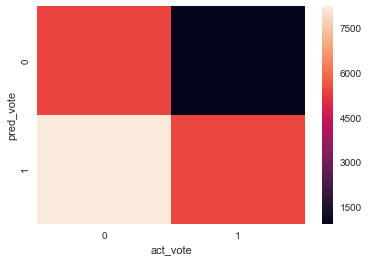

In [178]:
plt.show()

In [179]:
model_eval.head()

,Voter_ID,LAST.NAME,FIRST.NAME,likely_to_vote,Unnamed: 0,Voter_Name,Ballot_Type,Residence_Address,Zip_Code,Party,...,pctapi,pctaian,pct2prace,pcthispanic,guess,Dist_VotI_y,mo_supporter,Dist_VotI,pred_vote,act_vote
0,101116560,WARRENDAVIS,KAREN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,101116560,WARRENDAVIS,KAREN,0.977017,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,101138510,JEANBAPTISTE,DIDIER,0.966093,4389.0,JEANBAPTISTE| DIDIER,M,193 GRIFFITH ST AptUnit 2,73072926,DEM,...,0.43,0.11,9.62,2.04,black,0.0,0.0,20.0,1,1
3,101139593,WYATT,ROBERT,0.841616,562.0,WYATT| ROBERT,M,126 WEBSTER AVE AptUnit 4E,7307,DEM,...,0.34,0.55,1.50,1.80,white,0.0,0.0,3.0,1,1
4,101173448,PURVIS,ANGEL,0.619970,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [180]:
#https://ocefpaf.github.io/python4oceanographers/blog/2015/02/02/cartopy_folium_shapefile/

In [181]:
import folium
import pandas as pd

In [182]:
JC_COORDINATES = (40.7437326, -74.0550381)

# for speed purposes
MAX_RECORDS = 1000

# create empty map zoomed in on San Francisco
map = folium.Map(location=JC_COORDINATES, zoom_start=12)
 
display(map)


In [183]:
# definition of the boundaries in the map
district_geo = r'JC_WardD.geojson'



In [184]:
model_eval.head()

,Voter_ID,LAST.NAME,FIRST.NAME,likely_to_vote,Unnamed: 0,Voter_Name,Ballot_Type,Residence_Address,Zip_Code,Party,...,pctapi,pctaian,pct2prace,pcthispanic,guess,Dist_VotI_y,mo_supporter,Dist_VotI,pred_vote,act_vote
0,101116560,WARRENDAVIS,KAREN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,101116560,WARRENDAVIS,KAREN,0.977017,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,101138510,JEANBAPTISTE,DIDIER,0.966093,4389.0,JEANBAPTISTE| DIDIER,M,193 GRIFFITH ST AptUnit 2,73072926,DEM,...,0.43,0.11,9.62,2.04,black,0.0,0.0,20.0,1,1
3,101139593,WYATT,ROBERT,0.841616,562.0,WYATT| ROBERT,M,126 WEBSTER AVE AptUnit 4E,7307,DEM,...,0.34,0.55,1.50,1.80,white,0.0,0.0,3.0,1,1
4,101173448,PURVIS,ANGEL,0.619970,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [185]:
# calculating total number of incidents per district
crimedata2 = pd.DataFrame(model_eval['Dist_VotI'].value_counts().astype(float))
crimedata2.to_json('crimeagg.json')
crimedata2 = crimedata2.reset_index()
crimedata2.columns = ['District', 'Number']



In [186]:
import os

map1 = folium.Map(location=JC_COORDINATES, zoom_start=12)


map1.choropleth(
                    geo_data=open('JC_WardD.geojson').read(),
                    data=crimedata2,
                    columns=['District', 'Number'],
                    key_on='features.geometry.properties.District',
                    fill_color='YlGn',
)

map1

AttributeError: 'NoneType' object has no attribute 'get'

In [187]:
pd.read_json('JC_WardD.geojson')["features"][0]["geometry"]

{u'coordinates': [[[618792.5421170034, 695136.4846226797],
   [618766.1944006719, 695107.648066178],
   [618764.478196755, 695105.7697890922],
   [618741.9729924202, 695076.191436179],
   [618728.0199363381, 695057.8528901786],
   [618699.8949925862, 695029.727946423],
   [618682.3356445022, 695005.362181507],
   [618675.110265255, 694995.9934338406],
   [618638.4499055035, 694903.2386980951],
   [618622.5500029214, 694863.010104008],
   [618620.6723820046, 694861.16135443],
   [618596.9614714198, 694837.817241013],
   [618571.2056174204, 694910.8374361768],
   [618573.4398649223, 694934.8787266761],
   [618550.3099899217, 694941.8301563412],
   [618470.730096586, 694974.6201170087],
   [618461.7901538387, 694978.7398594245],
   [618457.458141502, 694979.8963531777],
   [618453.6999469213, 694980.8999600932],
   [618447.1100650877, 694981.1299465075],
   [618441.2698536702, 694979.489857927],
   [618435.8801006712, 694976.779889591],
   [618431.2800442539, 694972.8300943449],
   [61841

In [188]:
coords = pd.read_json('JC_WardD.geojson')["features"][0]["geometry"]["coordinates"][0]

In [189]:
coords

[[618792.5421170034, 695136.4846226797],
 [618766.1944006719, 695107.648066178],
 [618764.478196755, 695105.7697890922],
 [618741.9729924202, 695076.191436179],
 [618728.0199363381, 695057.8528901786],
 [618699.8949925862, 695029.727946423],
 [618682.3356445022, 695005.362181507],
 [618675.110265255, 694995.9934338406],
 [618638.4499055035, 694903.2386980951],
 [618622.5500029214, 694863.010104008],
 [618620.6723820046, 694861.16135443],
 [618596.9614714198, 694837.817241013],
 [618571.2056174204, 694910.8374361768],
 [618573.4398649223, 694934.8787266761],
 [618550.3099899217, 694941.8301563412],
 [618470.730096586, 694974.6201170087],
 [618461.7901538387, 694978.7398594245],
 [618457.458141502, 694979.8963531777],
 [618453.6999469213, 694980.8999600932],
 [618447.1100650877, 694981.1299465075],
 [618441.2698536702, 694979.489857927],
 [618435.8801006712, 694976.779889591],
 [618431.2800442539, 694972.8300943449],
 [618415.7774505876, 694956.2582770959],
 [618397.0986821689, 694936.75